<a href="https://colab.research.google.com/github/arefin-nabil/Machine_Learning/blob/master/M9_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Outlier detection, feature transformation, domain-driven features, preprocessing pipelines, and a quick sanity-check model

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


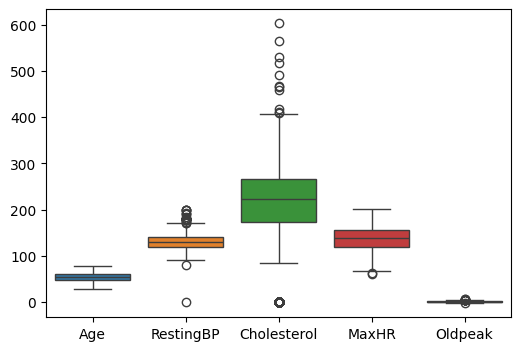

In [38]:
numeric_col = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

plt.figure(figsize=(6, 4))
sns.boxplot(data=df[numeric_col])
plt.show()

In [39]:
#Detect outliers using IQR method
col = "Cholesterol"     # RestingBP, Age,, anything
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3-Q1

lower = Q1 - 1.5*IQR
upper = Q1 + 1.5*IQR

outliers = df[(df[col]<lower) | (df[col]>upper)]
print(f"Outliers in {col}: ", len(outliers))

Outliers in Cholesterol:  240


Handling Outliers using 3 method              
log is better approach      
remove outliers when there is a huge dataset           
and cap is forcing a data ,, not always recommended

In [40]:
# Remove Outliers         # when i have a very large dataset
df_rmv_outlier = df[(df[col] >= lower) & (df[col] <=upper)]
print("After removing outliers : " , len(df_rmv_outlier))

# Cap outliers            # replacing lower outiers with lower value and upper outiers with upper value
df_capped = df.copy()
df_capped[col] = df_capped[col].clip(lower, upper)
print(df_capped)

# log transformation      #
df_log = df.copy()
df_log[col + "_log"] = np.log(df_log[col]+1)      # df_log[col + "_log"] othoba df[Cholesterol_log] {also +1 is mandatory}
print(df_log)

After removing outliers :  678
     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140        289.0          0     Normal   
1     49   F           NAP        160        180.0          0     Normal   
2     37   M           ATA        130        283.0          0         ST   
3     48   F           ASY        138        214.0          0     Normal   
4     54   M           NAP        150        195.0          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110        264.0          0     Normal   
914   68   M           ASY        144        193.0          1     Normal   
915   57   M           ASY        130        131.0          0     Normal   
916   57   F           ATA        130        236.0          0        LVH   
917   38   M           NAP        138        175.0          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDiseas

###Feature Transformation and Domain-Driven Features
feature was in a format (numarical) and then convert it to another human understandable format (categorycal) is feature transformation              
it is also known as binning,,, continuous data theke group of categorical data            



In [41]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial features using Age and MaxHR (if available)
poly_cols=["Age","MaxHR"]
poly = PolynomialFeatures(degree=2, include_bias=False)

poly_features = poly.fit_transform(df[poly_cols])
poly_feature_names = poly.get_feature_names_out(poly_cols)

print(poly_feature_names)
print(poly_features.shape)

['Age' 'MaxHR' 'Age^2' 'Age MaxHR' 'MaxHR^2']
(918, 5)


In [47]:
# Binning Age into categories (Yound, Middle, Old)        # bins = Basket
dff = df.copy()
dff["Age"] = pd.cut(
    dff["Age"],
    bins=[0, 20, 40, 60, 100],
    labels=["Young", "Middle", "Middle Old", "Old"]
)
dff["Age"].head(10)


,Age
0,Middle
1,Middle Old
2,Middle
3,Middle Old
4,Middle Old
5,Middle
6,Middle Old
7,Middle Old
8,Middle
9,Middle Old


In [49]:
# Domain-driven risk categories for restingBP and Oldpeak   # data jei domain er, oi domain er term use kora

def bp_risk(bp):
  if bp<120:
    return "Normal"
  elif bp<140:
    return "Elevated"
  else:
    return "High"

def oldpeak_risk(op):
  if op==0:
    return "No Stress"
  elif op<2:
    return "Moderate Stress"
  else:
    return "High Stress"

dff["BP_Risk"]=dff["RestingBP"].apply(bp_risk)
dff["Oldpeak_Risk"]=dff["Oldpeak"].apply(oldpeak_risk)
dff[["RestingBP", "BP_Risk", "Oldpeak","Oldpeak_Risk"]]


,RestingBP,BP_Risk,Oldpeak,Oldpeak_Risk
0,140,High,0.0,No Stress
1,160,High,1.0,Moderate Stress
2,130,Elevated,0.0,No Stress
3,138,Elevated,1.5,Moderate Stress
4,150,High,0.0,No Stress
...,...,...,...,...
913,110,Normal,1.2,Moderate Stress
914,144,High,3.4,High Stress
915,130,Elevated,1.2,Moderate Stress
916,130,Elevated,0.0,No Stress


In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define numeric and categorical columns for the pipeline
num_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
cat_features = ["Sex", "ExerciseAngina", "ChestPainType", "RestingECG", "ST_Slope"]

# Numeric pipeline
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ("ohe",OneHotEncoder(drop="first"))
])

# Combine both
preprocess = ColumnTransformer([
    ("num",num_pipeline,num_features),
    ("cat",cat_pipeline,cat_features)
])

# Full pipeline with a simple model
clf = Pipeline([
   ("prep",preprocess),
   ("model",LogisticRegression(max_iter=1000))
])


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Train-test split using original df_heart (not already encoded)

X = df.drop(columns=["HeartDisease"])
y = df["HeartDisease"]

X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(
    X, y, test_size = 0.25, random_state = 42
)

# Fit the full pipeline
clf.fit(X_train_pipe, y_train_pipe)

# Predict and evaluate
from sklearn.metrics import accuracy_score

y_pred_pipe = clf.predict(X_test_pipe)
acc=accuracy_score(y_test_pipe,y_pred_pipe)
print("Logistic Regression with preprocessing pipeline: ", acc)

Logistic Regression with preprocessing pipeline:  0.8434782608695652
